In [1]:
import json
import pandas as pd
from yome import Session
from yome.models import *
from yome.util import to_df, report
import re

In [12]:
from sqlalchemy import exists, distinct
from sqlalchemy.orm import aliased

In [59]:
df = pd.read_table('../data/wgcna-output-2018-11-02-14:24:35/final-membership.txt', sep='\t')

In [60]:
df.head()

,Gene,Module,kME
0,b0001,P6_I2_M2,0.89
1,b0002,UNCLASSIFIED,NaN
2,b0003,UNCLASSIFIED,NaN
3,b0004,UNCLASSIFIED,NaN
4,b0005,UNCLASSIFIED,NaN


# TODOs
- get gene names & ecocyc descriptions for all genes in each module
- plot correlation for a couple examples to confirm groups
- try clustering on log expression
- read interativeWGCNA & WGCNA papers
  + https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html

# get gene names & descriptions

In [8]:
session = Session()

In [13]:
# List EcoCyc feature types
(session.query(distinct(KnowledgebaseFeature.feature_type))
 .join(KnowledgebaseGene)
 .join(Knowledgebase)
 .filter(Knowledgebase.name == 'EcoCyc')).all()

[('summary_html'),
 ('product_type'),
 ('is_pseudogene'),
 ('is_phantom_gene'),
 ('is_insertion_element'),
 ('description'),
 ('ec_number'),
 ('reaction_equation'),
 ('evidence_html'),
 ('component_html')]

In [15]:
# EcoCyc descriptions
ec = to_df((
    session.query(Gene.locus_id, 
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
).all(), ['locus_tag', 'primary_name', 'description'])

In [16]:
ec.head()

,locus_tag,primary_name,description
0,b2331,smrB,putative endonuclease SmrB
1,b2038,rfbC,"dTDP-4-dehydrorhamnose 3,5-epimerase"
2,b0693,speF,"ornithine decarboxylase, degradative"
3,b0928,aspC,aspartate aminotransferase
4,b1056,yceI,protein YceI


# Join to clusters

In [61]:
clusters = df.rename(columns={'Gene': 'locus_tag'}).merge(ec)

In [62]:
g_clusters = clusters.groupby('Module')

In [63]:
g_clusters.get_group('P1_I4_M3').sort_values('kME', ascending=False)

,locus_tag,Module,kME,primary_name,description
1733,b1885,P1_I4_M3,0.90,tap,methyl-accepting chemotaxis protein - dipeptid...
1001,b1082,P1_I4_M3,0.89,flgK,flagellar hook-filament junction protein 1
1734,b1886,P1_I4_M3,0.89,tar,methyl-accepting chemotaxis protein Tar
1784,b1946,P1_I4_M3,0.87,fliN,flagellar motor switch protein FliN
1726,b1878,P1_I4_M3,0.86,flhE,flagellar protein
3988,b4355,P1_I4_M3,0.86,tsr,methyl-accepting chemotaxis protein - serine-s...
991,b1072,P1_I4_M3,0.85,flgA,flagellar basal body P-ring formation protein ...
1002,b1083,P1_I4_M3,0.85,flgL,flagellar hook-filament junction protein 2
1735,b1887,P1_I4_M3,0.85,cheW,chemotaxis protein CheW
1762,b1921,P1_I4_M3,0.85,fliZ,DNA-binding transcriptional regulator FliZ


# Check in expression set

In [64]:
exp = pd.read_table('../data/sbrg_rnaseq_matrix_log.tsv', sep='\t', index_col='locus_tag')

In [65]:
exp.head()

,ac_9_92_3,ac_9_92_4,bw25113_ac,bw25113_ade,bw25113_aero,bw25113_anaero,bw25113_delcra_glc,bw25113_delcra_trp,bw25113_delmntr_aero,bw25113_delmntr_anaero,...,wt_m9,wt_ph5,wt_pq,wt_thr,xyl_2_165,xyl_3_165,xyl_ale1,xyl_ale2,xyl_ale3,xyl_ale4
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0001,13.770924,13.308161,0.000000,5.592462,5.643192,4.025586,7.680922,6.984606,0.000000,9.718731,...,9.291450,12.762223,14.963023,14.647357,11.683149,11.364939,12.095438,10.609221,10.616990,7.630916
b0002,15.837947,15.373451,15.603140,15.392034,11.917610,0.000000,11.658951,13.941731,12.281578,9.609516,...,11.387905,7.256953,16.861858,16.776122,12.698494,8.204643,13.589615,14.233082,14.205937,10.798740
b0003,13.521833,13.393281,13.027301,13.652369,9.467258,8.220955,7.453621,12.308754,0.000000,9.753582,...,9.482553,9.084445,13.816100,13.768966,9.950279,7.739278,11.227867,11.835359,11.769700,9.914883
b0004,13.974765,14.189070,14.208539,13.720997,9.258390,7.668252,9.261670,12.775336,6.048270,0.000000,...,10.523160,9.875093,15.237609,14.852098,11.023438,0.000000,12.999713,12.902768,12.871275,11.375012
b0005,9.080893,9.256942,9.270403,7.861191,6.686869,0.000000,7.723515,8.413578,7.309451,5.784258,...,6.627055,7.445328,8.956711,8.232491,4.242157,0.000000,0.000000,0.000000,6.258376,5.591215


In [66]:
top2 = exp[exp.index.isin(['b1885', 'b1082'])].iloc[:, 1:].T

In [67]:
top2.head()

locus_tag,b1082,b1885
ac_9_92_4,9.534239,8.012971
bw25113_ac,8.535854,7.029573
bw25113_ade,10.166319,10.433493
bw25113_aero,13.523908,13.948588
bw25113_anaero,13.964345,14.404885


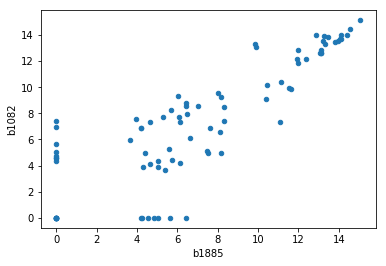

In [69]:
top2.plot(x='b1885', y='b1082', kind='scatter')

In [70]:
top2.corr()

locus_tag,b1082,b1885
locus_tag,,
b1082,1.000000,0.838711
b1885,0.838711,1.000000
